Downloading the Cifar10 dataset

In [ ]:
!wget https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz

Unzip downloaded files

In [ ]:
!tar -xzf cifar-10-python.tar.gz

Importing the used libraries

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import os
from scipy.ndimage import gaussian_filter
from keras.layers import Conv2D, BatchNormalization, Activation, Lambda, Dense, Input, Conv2D, MaxPooling2D, UpSampling2D
from keras.models import Model, Input
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.optimizers import Adam
import keras.backend as K
import random

Using TensorFlow backend.


This function will be used to open the dataset files

In [ ]:
def load_pickle(f):
  import pickle
  return  pickle.load(f, encoding='latin1')

This function will load the files and reshape the 'Data' part into batches

In [ ]:
def load_CIFAR_batch(filename):
    with open(filename, 'rb') as f:
        data = load_pickle(f)
        myDict = data['data']
        myDict = myDict.reshape(10000,3072)
        return myDict

Loading files from the sub directories of the classes as well as the test files

In [ ]:
def load_CIFAR10(ROOT):
    liste = []
    for b in range(1,6):
        f = os.path.join(ROOT, 'data_batch_%d' % (b, ))
        X = load_CIFAR_batch(f)
        liste.append(X)
    data_batch = np.concatenate(liste)
    del X
    test_batch = load_CIFAR_batch(os.path.join(ROOT, 'test_batch'))
    return data_batch, test_batch

Here I am splitting the dataset into training, validation and testing sets, Reshaping them into the correct shapes and channels and normalising them.

In [ ]:
def get_CIFAR10_data(training=49000, validation=1000, test=10000):
    cifar10_dir = 'cifar-10-batches-py/'
    X_train, X_test = load_CIFAR10(cifar10_dir)

    mask = range(training, training + validation)
    X_val = X_train[mask]
    mask = range(training)
    X_train = X_train[mask]
    mask = range(test)
    X_test = X_test[mask]

    x_train = X_train.astype('float32')
    x_test = X_test.astype('float32')
    x_val = X_val.astype('float32')

    x_train /= 255
    x_test /= 255
    x_val /= 255

    ##The data channels got inverted so I'm correcting the channels before returning the images

    return x_train.reshape(num_training,3, 32, 32).transpose(0,2,3,1), x_val.reshape(num_validation,3, 32, 32).transpose(0,2,3,1), x_test.reshape(num_test,3, 32, 32).transpose(0,2,3,1)

In [ ]:
Y_training, Y_validation, Y_testing = get_CIFAR10_data()

Here we apply a gaussian blurring with random std between 0 and 3

In [ ]:
X_training = np.zeros(shape=(Y_training.shape))
X_validation = np.zeros(shape=(Y_validation.shape))
X_testing = np.zeros(shape=(Y_testing.shape))
for i in range(len(Y_training)):
  X_training[i] = gaussian_filter(Y_training[i], random.uniform(0, 3))
for i in range(len(Y_validation)):
  X_validation[i] = gaussian_filter(Y_validation[i], random.uniform(0, 3))
for i in range(len(Y_testing)):
  X_testing[i] = gaussian_filter(Y_testing[i], random.uniform(0, 3))

Here is an example of an image before applying the blurring

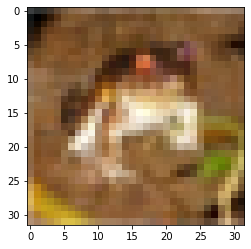

In [ ]:
plt.imshow(Ytr[0])

And here is an example of the image after applying the blurring

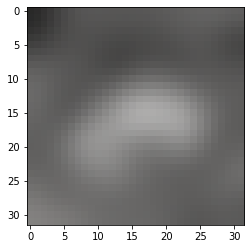

In [ ]:
plt.imshow(Xtr[0])

Since deblurring is a special case of denoising I wanted first to test the autoencoder as it is explained in the keras blog

Here we are trying with a Convolutional autoencoder, a network with convolution layers for both encoding and decoding.
I used MSE as a loss function

In [ ]:
input_img = Input(shape=(32, 32, 3))

x = Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)


x = Conv2D(8, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(16, (1, 1), activation='relu')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)




autoencoder = Model(input_img, decoded)
adam = Adam(lr= 0.001)
autoencoder.compile(optimizer= adam, loss= 'mean_squared_error')

After compiling the model, I'll add a checkpointer to save weights after each epoch, and also the earlystopping function to stop the learning after 10 epoches when the learning starts to get worst

In [ ]:
checkpointer = ModelCheckpoint(filepath='model_1.hdf5', verbose=1, save_best_only=True)
earlystopping = EarlyStopping(monitor='val_loss', min_delta=0.00001, patience=10, mode='auto')
autoencoder.fit(Xtr, Ytr,
                epochs=300,
                batch_size=256,
                shuffle=True,
               callbacks=[ checkpointer, earlystopping],
                validation_data=(Xval, Yval))

Here we load  the best weights from the saved file

In [ ]:
autoencoder.load_weights("model_1.hdf5")

Let's see the result on some random images from testset

In [ ]:
#random samples from test set
ids = np.random.randint(0, len(Xte), 10)
samples = Xte[ids]

In [ ]:
pred = autoencoder.predict(samples)

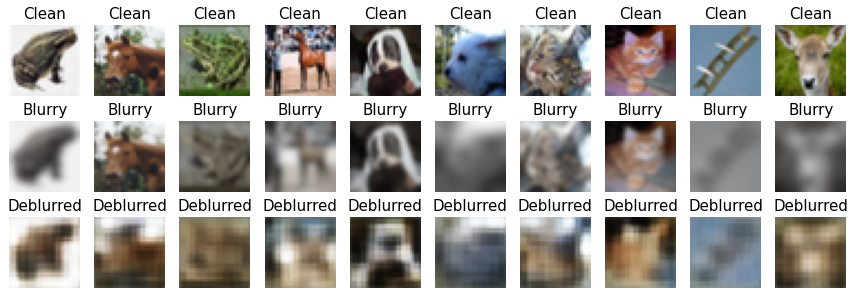

In [ ]:
f, ax = plt.subplots(3,10, figsize=(15,5))
for i in range(10):
    ax[0,i].imshow(Yte[ids[i]]);  ax[0,i].axis('Off'); ax[0,i].set_title('Clean', size=15)
    ax[1,i].imshow(Xte[ids[i]]);  ax[1,i].axis('Off'); ax[1,i].set_title('Blurry', size=15)
    ax[2,i].imshow(pred[i]);  ax[2,i].axis('Off'); ax[2,i].set_title('Deblurred', size=15)
plt.show()

As we can see the result are very bad

Finally we found an architecture that uses convolutional neural networks with many kernels from this paper that seems to focus on deblurring texts. And I managed to adapted for general image deblurring:
https://www.fit.vut.cz/research/publication-file/10922/hradis15CNNdeblurring.pdf

In [ ]:
layer_input = Input(shape=(32,32,3))

layer1 = Conv2D(filters=128, kernel_size=19, strides = 1, padding='same')(layer_input)
layer1 = BatchNormalization()(layer1)
layer1 = Activation('relu')(layer1)

layer2 = Conv2D(filters=320, kernel_size=1, strides = 1, padding='same')(layer1)
layer2 = BatchNormalization()(layer2)
layer2 = Activation('relu')(layer2)

layer3 = Conv2D(filters=320, kernel_size=1, strides = 1, padding='same')(layer2)
layer1 = BatchNormalization()(layer3)
layer1 = Activation('relu')(layer3)

layer4 = Conv2D(filters=320, kernel_size=1, strides = 1, padding='same')(layer3)
layer4 = BatchNormalization()(layer4)
layer4 = Activation('relu')(layer4)

layer5 = Conv2D(filters=128, kernel_size=1, strides = 1, padding='same')(layer4)
layer5 = BatchNormalization()(layer5)
layer5 = Activation('relu')(layer5)

layer6 = Conv2D(filters=128, kernel_size=3, strides = 1, padding='same')(layer5)
layer6 = BatchNormalization()(layer6)
layer6 = Activation('relu')(layer6)

layer7 = Conv2D(filters=512, kernel_size=1, strides = 1, padding='same')(layer6)
layer7 = BatchNormalization()(layer7)
layer7 = Activation('relu')(layer7)

layer8 = Conv2D(filters=128, kernel_size=5, strides = 1, padding='same')(layer7)
layer8 = BatchNormalization()(layer8)
layer8 = Activation('relu')(layer8)

layer9 = Conv2D(filters=128, kernel_size=5, strides = 1, padding='same')(layer8)
layer9 = BatchNormalization()(layer9)
layer9 = Activation('relu')(layer9)

layer10 = Conv2D(filters=128, kernel_size=3, strides = 1, padding='same')(layer9)
layer10 = BatchNormalization()(layer10)
layer10 = Activation('relu')(layer10)

layer11 = Conv2D(filters=128, kernel_size=5, strides = 1, padding='same')(layer10)
layer11 = BatchNormalization()(layer11)
layer11 = Activation('relu')(layer11)

layer12 = Conv2D(filters=128, kernel_size=5, strides = 1, padding='same')(layer11)
layer12 = BatchNormalization()(layer12)
layer12 = Activation('relu')(layer12)

layer13 = Conv2D(filters=256, kernel_size=1, strides = 1, padding='same')(layer12)
layer13 = BatchNormalization()(layer13)
layer13 = Activation('relu')(layer13)

layer14 = Conv2D(filters=64, kernel_size=7, strides = 1, padding='same')(layer13)
layer14 = BatchNormalization()(layer14)
layer14 = Activation('relu')(layer14)

output = Conv2D(filters=3, kernel_size=7, strides = 1, padding='same', activation='relu')(layer14)

deblur_network = Model(inputs= layer_input, outputs=output )

Here we compile the model

In [ ]:
adam = Adam(lr= 0.00001)
deblur_network.compile(optimizer= adam, loss= 'mean_squared_error')

And here I fit it and use at the same time a checkpointer to save best weights and a stopper to prevent overfitting

In [ ]:
from keras.callbacks import ModelCheckpoint, EarlyStopping
checkpointer = ModelCheckpoint(filepath='model.hdf5', verbose=1, save_best_only=True)
earlystopping = EarlyStopping(monitor='val_loss', min_delta=0.001, patience=10, mode='auto')
deblur_network.fit(Xtr, Ytr,
                epochs=100,
                batch_size=128,
                shuffle=True,
               callbacks=[ checkpointer, earlystopping],
                validation_data=(Xval, Yval))

We load the best weights from saved file

In [ ]:
deblur_network.load_weights("model.hdf5")

Let's try to deblur some random test images

In [ ]:
#random samples from test set
ids = np.random.randint(0, len(Xte), 10)
samples = Xte[ids]
pred = deblur_network.predict(samples)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


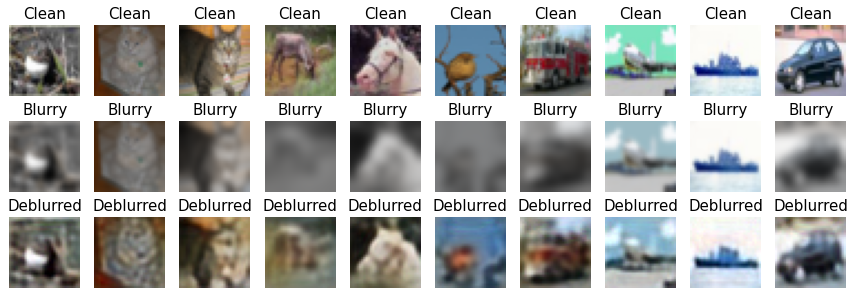

In [ ]:
f, ax = plt.subplots(3,10, figsize=(15,5))
for i in range(10):
    ax[0,i].imshow(Yte[ids[i]]);  ax[0,i].axis('Off'); ax[0,i].set_title('Clean', size=15)
    ax[1,i].imshow(Xte[ids[i]]);  ax[1,i].axis('Off'); ax[1,i].set_title('Blurry', size=15)
    ax[2,i].imshow(pred[i]);  ax[2,i].axis('Off'); ax[2,i].set_title('Deblurred', size=15)
plt.show()

The results are very good and better than the previous networks

#Part II

Download REDS dataset, with motion-like blurring.
Since the trainset is huge(26 GB), we will work only with validation set as our training set

In [ ]:
!wget https://cv.snu.ac.kr/~snah/Deblur/dataset/REDS/val_blur.zip
!wget https://cv.snu.ac.kr/~snah/Deblur/dataset/REDS/test_blur.zip
!wget https://cv.snu.ac.kr/~snah/Deblur/dataset/REDS/val_sharp.zip

In [ ]:
!unzip val_blur.zip
!unzip val_sharp.zip
!unzip test_blur.zip

In [ ]:
train_names_x = []
train_names_y = []
for path, sub,files in os.walk('val/val_sharp'):
    for name in files:
        train_names_y.append(os.path.join(path, name))
for path, sub, files in os.walk('val/val_blur'):
    for name in files:
        train_names_x.append(os.path.join(path, name))

from scipy import ndimage
from keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img

train_x = np.ndarray(shape=(len(train_names_x), 500,500, 3), dtype=np.float32)
train_y = np.ndarray(shape=(len(train_names_y), 500,500, 3), dtype=np.float32)
i = 0
for file in train_names_x:
    img = load_img(file)  # this is a PIL image
    print(file)
    img = img.resize((500,500))
    # Convert to Numpy Array
    x = img_to_array(img)  
    # Normalize
    x = x / 127.5 - 1
    train_x[i] = x
    i += 1
i = 0
for file in train_names_y:
    img = load_img(file)  # this is a PIL image
    print(file)
    img = img.resize((500,500))
    # Convert to Numpy Array
    x = img_to_array(img)
    # Normalize
    x = x / 127.5 - 1
    train_y[i] = x
    i += 1

In [ ]:
from sklearn.model_selection import train_test_split
Xtr, Xval, Ytr, Yval = train_test_split(train_x, train_y, test_size=0.2)

In [ ]:
import gc
gc.collect()

Let's use the previous netwok for this dataset

In [ ]:
layer_input = Input(shape=(500,500,3))

layer1 = Conv2D(filters=128, kernel_size=19, strides = 1, padding='same')(layer_input)
layer1 = BatchNormalization()(layer1)
layer1 = Activation('relu')(layer1)

layer2 = Conv2D(filters=320, kernel_size=1, strides = 1, padding='same')(layer1)
layer2 = BatchNormalization()(layer2)
layer2 = Activation('relu')(layer2)

layer3 = Conv2D(filters=320, kernel_size=1, strides = 1, padding='same')(layer2)
layer1 = BatchNormalization()(layer3)
layer1 = Activation('relu')(layer3)

layer4 = Conv2D(filters=320, kernel_size=1, strides = 1, padding='same')(layer3)
layer4 = BatchNormalization()(layer4)
layer4 = Activation('relu')(layer4)

layer5 = Conv2D(filters=128, kernel_size=1, strides = 1, padding='same')(layer4)
layer5 = BatchNormalization()(layer5)
layer5 = Activation('relu')(layer5)

layer6 = Conv2D(filters=128, kernel_size=3, strides = 1, padding='same')(layer5)
layer6 = BatchNormalization()(layer6)
layer6 = Activation('relu')(layer6)

layer7 = Conv2D(filters=512, kernel_size=1, strides = 1, padding='same')(layer6)
layer7 = BatchNormalization()(layer7)
layer7 = Activation('relu')(layer7)

layer8 = Conv2D(filters=128, kernel_size=5, strides = 1, padding='same')(layer7)
layer8 = BatchNormalization()(layer8)
layer8 = Activation('relu')(layer8)

layer9 = Conv2D(filters=128, kernel_size=5, strides = 1, padding='same')(layer8)
layer9 = BatchNormalization()(layer9)
layer9 = Activation('relu')(layer9)

layer10 = Conv2D(filters=128, kernel_size=3, strides = 1, padding='same')(layer9)
layer10 = BatchNormalization()(layer10)
layer10 = Activation('relu')(layer10)

layer11 = Conv2D(filters=128, kernel_size=5, strides = 1, padding='same')(layer10)
layer11 = BatchNormalization()(layer11)
layer11 = Activation('relu')(layer11)

layer12 = Conv2D(filters=128, kernel_size=5, strides = 1, padding='same')(layer11)
layer12 = BatchNormalization()(layer12)
layer12 = Activation('relu')(layer12)

layer13 = Conv2D(filters=256, kernel_size=1, strides = 1, padding='same')(layer12)
layer13 = BatchNormalization()(layer13)
layer13 = Activation('relu')(layer13)

layer14 = Conv2D(filters=64, kernel_size=7, strides = 1, padding='same')(layer13)
layer14 = BatchNormalization()(layer14)
layer14 = Activation('relu')(layer14)

output = Conv2D(filters=3, kernel_size=7, strides = 1, padding='same', activation='relu')(layer14)

deblur_network = Model(inputs= layer_input, outputs=output )

Use also PSNR as a metric of image quality

In [ ]:
def PSNR(y_true, y_pred):
    max_pixel = 1.0
    return (10.0 * K.log((max_pixel ** 2) / (K.mean(K.square(y_pred - y_true + 1e-8), axis=-1)))) / 2.303

Compile the model with adam as an optimizer and mse as loss function and PSNR as metric

In [ ]:
adam = Adam(lr= 0.00001)
deblur_network.compile(optimizer= adam, loss= 'mean_squared_error', metrics=[PSNR])

In [ ]:
from keras.callbacks import ModelCheckpoint, EarlyStopping
checkpointer = ModelCheckpoint(filepath='drive/My Drive/model_DES.hdf5', verbose=1, save_best_only=True)
earlystopping = EarlyStopping(monitor='val_loss', min_delta=0.001, patience=10, mode='auto')
deblur_network.fit(Xtr, Ytr,
                epochs=100,
                batch_size=6,
                shuffle=True,
               callbacks=[ checkpointer, earlystopping],
                validation_data=(Xval, Yval))

Extract images from files into numpy arrays to pass them to the model.

In [ ]:
test_names_x =[]
for path, subdirs, files in os.walk('test/test_blur'):
    for name in files:
        test_names_x.append(os.path.join(path, name))

In [ ]:
from scipy import ndimage
from keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img

test_x = np.ndarray(shape=(len(test_names_x), 500,500, 3), dtype=np.float32)
i = 0
for _file in test_names_x:
    img = load_img(_file)  # this is a PIL image
    img = img.resize((500,500))
    # Convert to Numpy Array
    x = img_to_array(img)  
    # Normalize
    x = x / 127.5 - 1
    test_x[i] = x
    i += 1

randomly select samples from the test set and pass them to the trained model

In [ ]:
#random samples from test set
ids = np.random.randint(0, len(test_x), 10)
samples = test_x[ids]
pred = deblur_network.predict(samples)
generated = pred * 127.5 + 127.5

plot the results.
As you notice. There is some improuvement but still the results are a bit poor

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

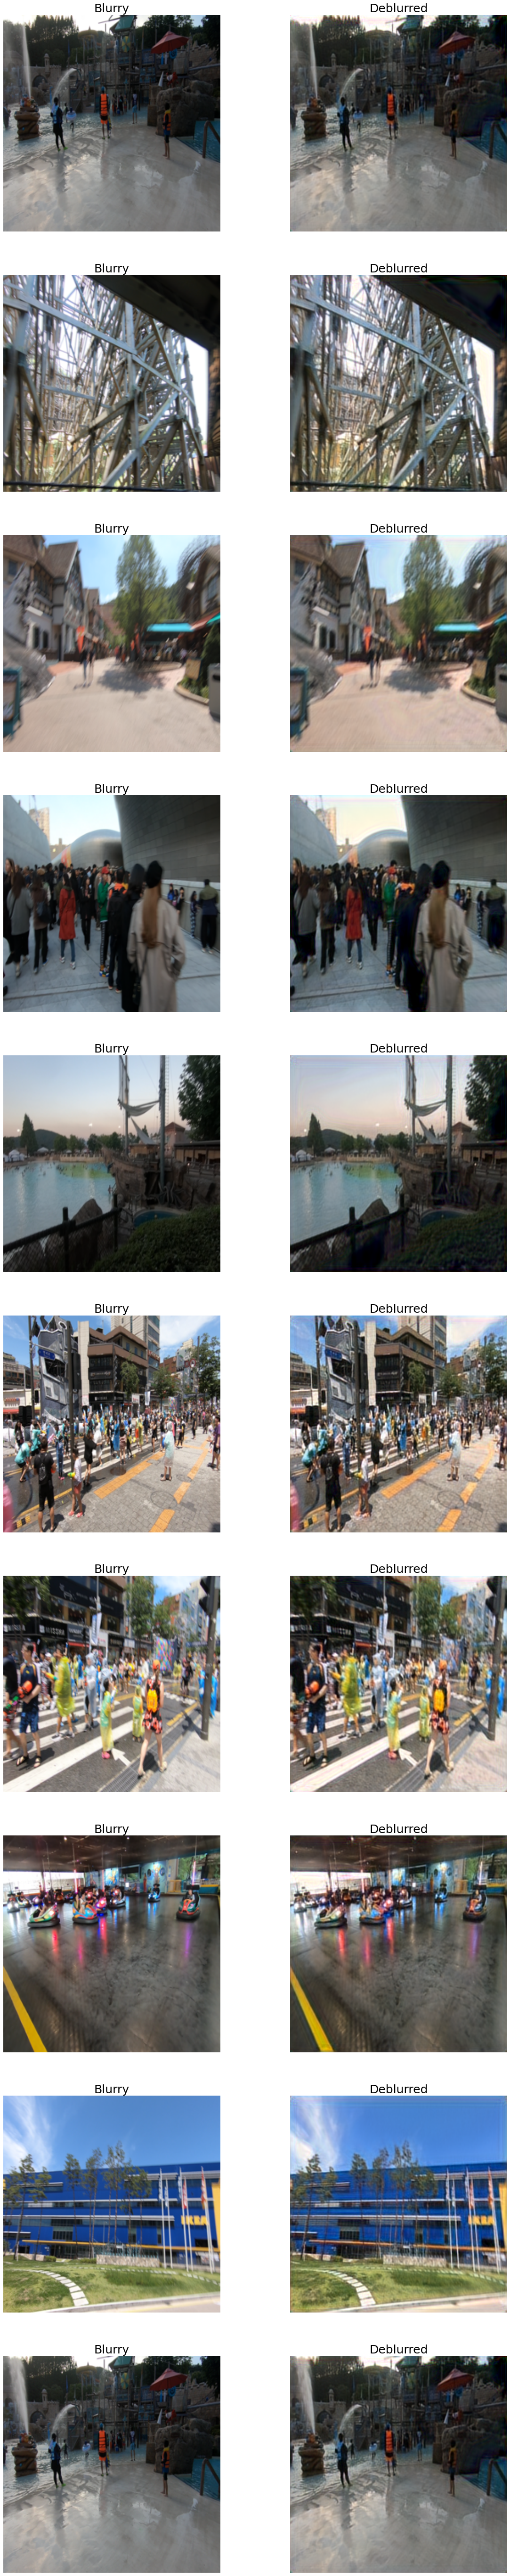

In [ ]:
f, ax = plt.subplots(10,2, figsize=(20,100))
for i in range(10):
    ax[i,0].imshow(test_x[ids[i]]* 127.5 + 127.5);  ax[i,0].axis('Off'); ax[i,0].set_title('Blurry', size=25)
    ax[i,1].imshow(generated[i]);  ax[i,1].axis('Off'); ax[i,1].set_title('Deblurred', size=25)
plt.show()